In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


No projector specified for this dataset. Please consider the method self.add_proj.


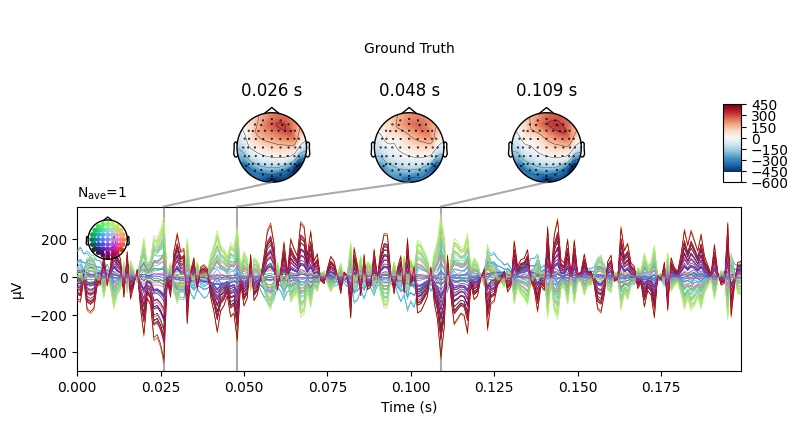

In [99]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=10,
    n_orders=(0, 0),
    snr_range=(1e99, 2e99),
    n_timecourses=200,
    n_timepoints=200,
    scale_data=False)

gen = generator(fwd, **sim_params)

x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)
                        
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Algo

In [121]:
from gradient_free_optimizers import HillClimbingOptimizer, ParticleSwarmOptimizer, SimulatedAnnealingOptimizer, PatternSearch, RandomAnnealingOptimizer
# search_space = {f"x{i+1}": np.arange(0, 1, 0.01) for i in range(n_dipoles)}
search_space = {f"x{i+1}": np.array([0,1]) for i in range(n_dipoles)}


def function(L, Y, lam=10):
    Y -= Y.mean(axis=0)
    Y /= abs(Y).mean()
    L -= L.mean(axis=0)
    L /= np.linalg.norm(L, axis=0)
    
    def source_function(search_space):
        gammas = np.array(list(search_space.values()))
        gammas[gammas<1e-3] = 0
        Gamma = np.diag(gammas)
        Sigma_y = L @ Gamma @ L.T
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        x = Gamma @ L.T @ Sigma_y_inv @ Y

        loss_data = np.linalg.norm(Y-L@x , ord=2)
        
        # loss_l1 = np.linalg.norm(x, ord=1)*lam
        loss_l1 = len(gammas) / (gammas==0).sum()*lam
        
        loss = loss_data + loss_l1
        return -loss
    
    def source_function2(search_space):
        ''' Negative log likelihood '''
        gammas = np.array(list(search_space.values()))
        # gammas[gammas<1e-3] = 0
        Gamma = np.diag(gammas)
        Sigma_y = L @ Gamma @ L.T
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        x = Gamma @ L.T @ Sigma_y_inv @ Y
        C_y = (Y@Y.T) / Y.shape[-1]

        _, logdet_sigma_y_estimated = np.linalg.slogdet(Sigma_y)
        neg_log_likelihood = logdet_sigma_y_estimated + abs(np.trace(C_y + Sigma_y_inv))
        return np.real(neg_log_likelihood)

    return source_function2

opt = HillClimbingOptimizer(search_space)
opt.search(function(leadfield, evoked.data), n_iter=1000)

gammas = np.array(list(opt.best_para.values()))
Gamma = np.diag(gammas)
Sigma_y = leadfield @ Gamma @ leadfield.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
x = Gamma @ leadfield.T @ Sigma_y_inv @ evoked.data

stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp, brain_kwargs=dict(title=f"{opt.name} {opt.n_iter}"))

stc_.data[:, 0] = gammas
stc_.plot(**pp, brain_kwargs=dict(title="gammas"))

print(f"best: {np.log(abs(opt.best_score))}")


Results: 'source_function2'  
   Best score: 53366711775041.21  
   Best parameter:
      'x1'    : 0  
      'x2'    : 1  
      'x3'    : 1  
      'x4'    : 0  
      'x5'    : 1  
      'x6'    : 0  
      'x7'    : 0  
      'x8'    : 0  
      'x9'    : 0  
      'x10'   : 1  
      'x11'   : 1  
      'x12'   : 1  
      'x13'   : 1  
      'x14'   : 1  
      'x15'   : 0  
      'x16'   : 0  
      'x17'   : 1  
      'x18'   : 0  
      'x19'   : 1  
      'x20'   : 1  
      'x21'   : 0  
      'x22'   : 0  
      'x23'   : 1  
      'x24'   : 1  
      'x25'   : 0  
      'x26'   : 1  
      'x27'   : 1  
      'x28'   : 0  
      'x29'   : 0  
      'x30'   : 1  
      'x31'   : 0  
      'x32'   : 0  
      'x33'   : 1  
      'x34'   : 1  
      'x35'   : 1  
      'x36'   : 0  
      'x37'   : 0  
      'x38'   : 1  
      'x39'   : 0  
      'x40'   : 0  
      'x41'   : 1  
      'x42'   : 1  
      'x43'   : 1  
      'x44'   : 0  
      'x45'   : 0  
      'x46'   :

Using control points [0.0923181  0.11589944 0.55092882]


Traceback (most recent call last):
  File "c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\utils.py", line 59, in safe_event
    return fun(*args, **kwargs)
  File "c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\_brain\_brain.py", line 546, in _clean
    self.clear_glyphs()
  File "c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\_brain\_brain.py", line 1464, in clear_glyphs
    assert sum(len(v) for v in self.picked_points.values()) == 0
AssertionError
Traceback (most recent call last):
  File "c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\utils.py", line 59, in safe_event
    return fun(*args, **kwargs)
  File "c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\_brain\_brain.py", line 546, in _clean
    self.clear_glyphs()
  File "c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\_brain\_brain.py", line 1464, in clear_glyphs
    assert sum(len(v) for v in self.picked_points.values()) == 0
AssertionError
Traceback (most recent call last):
 

In [120]:
np.array(list(opt.best_para.values()))

array([1, 1, 0, ..., 0, 0, 1])